In [460]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


def generate_data(num):
    num_a = num // 2
    num_b = num - num_a
    a = np.random.randn(num_a, 2)
    b = np.random.randn(num_b, 2)
    a[:, 0] = 0.1 * a[:, 0]
    b[:, 0] = 0.1 * b[:, 0]

    theta = np.random.rand()
    mat = [[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]]
    mat = np.array(mat).transpose()
    a = a @ mat
    
    theta += np.random.rand()
    mat = [[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]]
    mat = np.array(mat).transpose()
    b = b @ mat
    data = np.concatenate([a, b], axis=0)
    data += [1., -1.]

    mean = data.mean(axis=0)
    data = data - mean

    return data, mean

def normalize_transform(x):
    cov = x.transpose() @ x / (len(x) - 1.)
    eig_val, eig_vec = np.linalg.eig(cov)
    return [eig_val, eig_vec]

def to_model_space(x_real, params):
    eig_val, eig_vec = params
    return x_real @ eig_vec @ np.diag(np.power(eig_val, -0.5)) @ eig_vec.transpose()

def to_data_space(x_model, params):
    eig_val, eig_vec = params
    return x_model @ eig_vec @ np.diag(np.power(eig_val, 0.5)) @ eig_vec.transpose()

def normality(x):
    g = x.cosh().log().mean().pow(2.)
    # g += x.pow(2.).mul(-0.5).exp().mean().pow(2.)
    return - g

In [461]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.w = nn.Parameter(torch.randn(2, 2))

    def forward(self, x):
        return x @ self.w

    def norm(self):
        return self.w.transpose(1, 0) @ self.w

    def axis(self):
        w = self.w.data.detach()
        w /= w.pow(2).sum(dim=0, keepdim=True).pow(0.5)
        return w.detach().numpy().transpose()

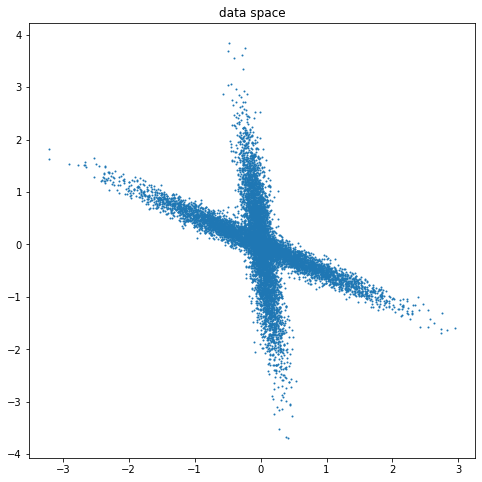

In [471]:
x_real, mean = generate_data(10000)

plt.figure(figsize=(8,8))

plt.scatter(x_real[:, 0], x_real[:, 1], s=1)

plt.title('data space')
plt.show()
transform = normalize_transform(x_real)

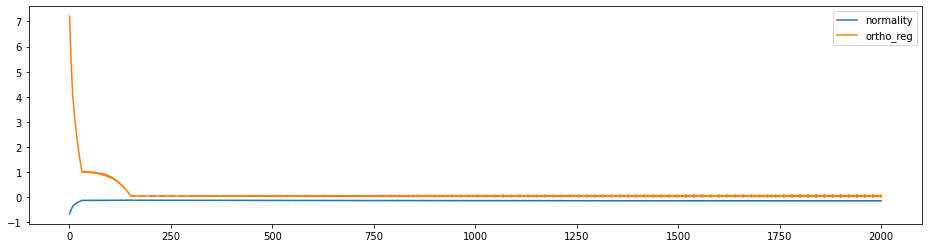

-0.1385190337896347


In [472]:
def ortho_L1(norm):
    eye = torch.eye(len(norm))
    lower_one = torch.tril(torch.ones_like(eye))
    l1 = (torch.eye(len(norm)) - net.norm()).abs() * lower_one
    l1 = l1.sum()
    return l1

def ortho_L2(norm):
    eye = torch.eye(len(norm))
    lower_one = torch.tril(torch.ones_like(eye))
    l2 = (torch.eye(len(norm)) - net.norm()).pow(2.) * lower_one
    l2 = l2.sum()
    return l2

net = Net()
xw = to_model_space(x_real, transform)
optimizer = torch.optim.SGD(net.parameters(), 1e-2)
avg_normality, avg_ortho_reg = [], []
for ep in range(2000):
    optimizer.zero_grad()
    y = net(torch.FloatTensor(xw))
    normality_loss = normality(y)
    ortho_reg_loss = ortho_L1(net.norm())
    loss = normality_loss + ortho_reg_loss # minimize normality
    loss.backward()
    optimizer.step()
    avg_normality.append(normality_loss.item())
    avg_ortho_reg.append(ortho_reg_loss.item())


plt.figure(figsize=(16, 4))
plt.plot(range(1, 1 + len(avg_normality)), avg_normality, label='normality')
plt.plot(range(1, 1 + len(avg_ortho_reg)), avg_ortho_reg, label='ortho_reg')
plt.legend()
plt.show()
print(avg_normality[-1])

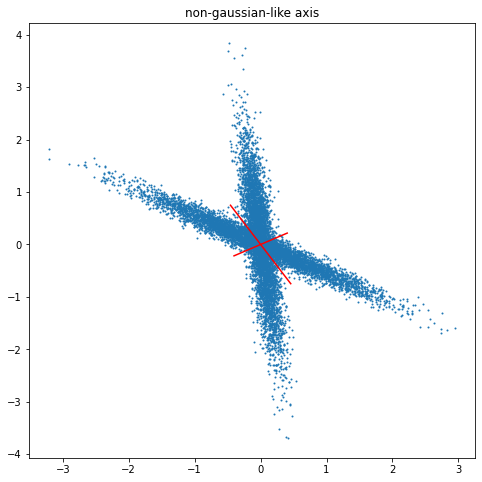

In [473]:
axis = net.axis()

axis = to_data_space(axis, transform)

plt.figure(figsize=(8,8))
plt.scatter(x_real[:, 0], x_real[:, 1], s=1)
plt.title('non-gaussian-like axis')

plt.plot([-axis[0][0], axis[0][0]], [-axis[0][1], axis[0][1]], c='#FF0000')
plt.plot([-axis[1][0], axis[1][0]], [-axis[1][1], axis[1][1]], c='#FF0000')

plt.show()


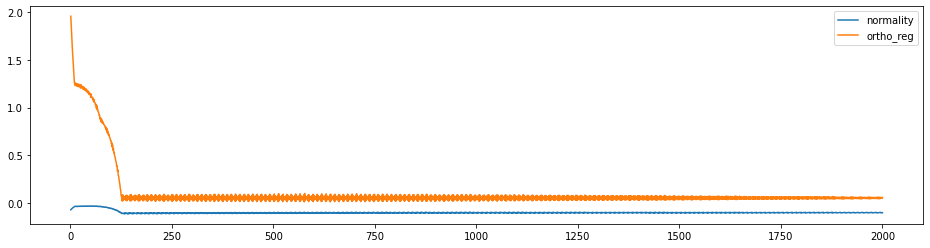

-0.10531304776668549


In [474]:
def ortho_L1(norm):
    eye = torch.eye(len(norm))
    lower_one = torch.tril(torch.ones_like(eye))
    l1 = (torch.eye(len(norm)) - net.norm()).abs() * lower_one
    l1 = l1.sum()
    return l1

def ortho_L2(norm):
    eye = torch.eye(len(norm))
    lower_one = torch.tril(torch.ones_like(eye))
    l2 = (torch.eye(len(norm)) - net.norm()).pow(2.) * lower_one
    l2 = l2.sum()
    return l2

net = Net()
xw = to_model_space(x_real, transform)
optimizer = torch.optim.SGD(net.parameters(), 1e-2)
avg_normality, avg_ortho_reg = [], []
for ep in range(2000):
    optimizer.zero_grad()
    y = net(torch.FloatTensor(xw))
    normality_loss = normality(y)
    ortho_reg_loss = ortho_L1(net.norm())
    loss = -normality_loss + ortho_reg_loss # maximize normality
    loss.backward()
    optimizer.step()
    avg_normality.append(normality_loss.item())
    avg_ortho_reg.append(ortho_reg_loss.item())


plt.figure(figsize=(16, 4))
plt.plot(range(1, 1 + len(avg_normality)), avg_normality, label='normality')
plt.plot(range(1, 1 + len(avg_ortho_reg)), avg_ortho_reg, label='ortho_reg')
plt.legend()
plt.show()
print(avg_normality[-1])

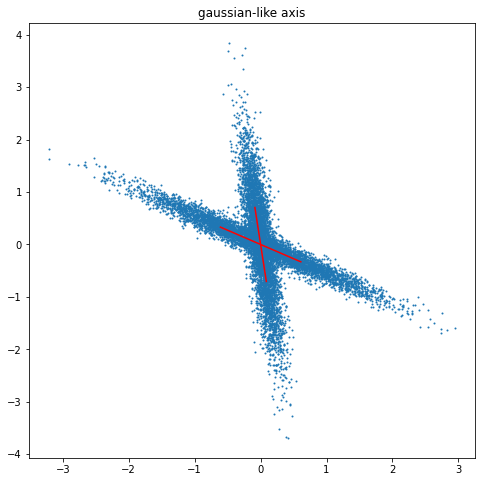

In [475]:
axis = net.axis()


xr = to_data_space(xw, transform)
plt.figure(figsize=(8,8))
plt.scatter(x_real[:, 0], x_real[:, 1], s=1)

plt.title('gaussian-like axis')

ax = to_data_space(axis, transform)
plt.plot([-ax[0][0], ax[0][0]], [-ax[0][1], ax[0][1]], c='#FF0000')
plt.plot([-ax[1][0], ax[1][0]], [-ax[1][1], ax[1][1]], c='#FF0000')

plt.show()
